In [16]:
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [18]:
def model_inputs(real_dim,z_dim):
    real_inp = tf.placeholder(dtype='float32',shape=[None,real_dim])
    z_inp = tf.placeholder(dtype='float32',shape=[None,z_dim])
    return real_inp,z_inp

In [19]:
def generator(z,out_dim,n_units,alpha,reuse=False):
    with tf.variable_scope('generator',reuse=reuse):
        layer1 = tf.layers.dense(z,n_units,activation=None)
        layer1 = tf.nn.leaky_relu(layer1,alpha=alpha)
        layer2 = tf.layers.dense(layer1,out_dim,activation=tf.nn.tanh)
        return layer2
        

In [20]:
def discriminator(x,n_units,alpha,reuse=False):
    with tf.variable_scope('discriminator',reuse=reuse):
        layer1 = tf.layers.dense(x,n_units,activation=None)
        layer1 = tf.nn.leaky_relu(layer1,alpha=alpha)
        layer2 = tf.layers.dense(layer1,1,activation=None)
        out = tf.nn.sigmoid(layer2)
        return layer2,out

In [21]:
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smoothing = 0.1

In [22]:
tf.reset_default_graph()
input_real,z_real = model_inputs(input_size,z_size)
g_model = generator(z_real,input_size,n_units=g_hidden_size,alpha=alpha)
d_real_log,d_real_out = discriminator(input_real,n_units=d_hidden_size,alpha=alpha)
d_fake_log,d_fake_out = discriminator(g_model,n_units=d_hidden_size,alpha=alpha,reuse=True)

In [23]:
lab = tf.ones_like(d_real_log)*(1-smoothing)
d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_log,labels=lab)
d_loss_real = tf.reduce_mean(d_loss_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_log,labels=tf.zeros_like(d_fake_log))
d_loss_fake = tf.reduce_mean(d_loss_fake)
d_loss = d_loss_real + d_loss_fake
g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_log,labels=tf.ones_like(d_fake_log))
g_loss = tf.reduce_mean(g_loss)

In [24]:
learning_rate = 0.001
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss,var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss,var_list=g_vars)

In [28]:
batch = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        for i in range(mnist.train.num_examples//batch):
            bat = mnist.train.next_batch(batch_size=batch)
            batch_images = bat[0].reshape((batch,784))
            batch_images = batch_images*2 - 1
            batch_z = np.random.uniform(-1,1,size=(batch,z_size))
            _ = sess.run(d_train_opt,feed_dict={input_real:batch_images,z_real:batch_z})
            _ = sess.run(g_train_opt,feed_dict={z_real:batch_z})
            
        train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,z_real:batch_z})
        train_loss_g = sess.run(g_loss,feed_dict={z_real:batch_z})
        print('Epoch:',epoch,'Dis loss:',train_loss_d,'Gen loss:',train_loss_g)
        losses.append((train_loss_d,train_loss_g))
        samp_z = np.random.uniform(-1,1,size=(8,z_size))
        im_sample = sess.run(generator(z_real,input_size,n_units=g_hidden_size,alpha=alpha,reuse=True),
                            feed_dict={z_real:samp_z})
        samples.append(im_sample)
        saver.save(sess,'./checkpoints/generator.ckpt')
        
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
    

Epoch: 0 Dis loss: 0.359525 Gen loss: 3.8268
Epoch: 1 Dis loss: 0.366946 Gen loss: 3.67953
Epoch: 2 Dis loss: 0.429366 Gen loss: 2.88036
Epoch: 3 Dis loss: 0.838542 Gen loss: 2.31504
Epoch: 4 Dis loss: 0.769873 Gen loss: 5.18181
Epoch: 5 Dis loss: 0.727508 Gen loss: 3.39824
Epoch: 6 Dis loss: 0.899187 Gen loss: 2.17584
Epoch: 7 Dis loss: 0.788145 Gen loss: 2.9936
Epoch: 8 Dis loss: 0.702328 Gen loss: 3.8863
Epoch: 9 Dis loss: 1.5539 Gen loss: 1.81831
Epoch: 10 Dis loss: 1.18592 Gen loss: 4.45037
Epoch: 11 Dis loss: 1.24817 Gen loss: 2.56259
Epoch: 12 Dis loss: 0.74551 Gen loss: 3.07549
Epoch: 13 Dis loss: 1.17208 Gen loss: 1.72858
Epoch: 14 Dis loss: 1.14899 Gen loss: 2.26703
Epoch: 15 Dis loss: 0.897991 Gen loss: 2.522
Epoch: 16 Dis loss: 0.840088 Gen loss: 2.15648
Epoch: 17 Dis loss: 1.75016 Gen loss: 1.10166
Epoch: 18 Dis loss: 0.977347 Gen loss: 1.71855
Epoch: 19 Dis loss: 0.866289 Gen loss: 3.25712
Epoch: 20 Dis loss: 0.938168 Gen loss: 2.56442
Epoch: 21 Dis loss: 1.33367 Gen loss

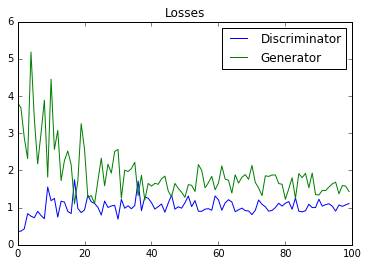

In [29]:
fig,ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0],label='Discriminator')
plt.plot(losses.T[1],label='Generator')
plt.title('Losses')
plt.legend()